In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA

import tensorflow as tf
from tensorflow.keras import layers, models


2024-09-18 10:08:25.283617: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
file_path = 'KDDTrain+.txt'

# Read the text file into a DataFrame without headers
train_df = pd.read_csv(file_path, header=None)

# Define the column names
columns = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land',
    'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised',
    'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
    'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count',
    'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate',
    'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
    'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
    'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate',
    'attack', 'level'
]


# Assign the column names to the DataFrame
train_df.columns = columns

# Display the first few rows with headers
print(f"Inital shape: {train_df.shape}")
keep_columns = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land',
    'wrong_fragment', 'urgent', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate',
    'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate',
    'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate',
    'dst_host_rerror_rate', 'dst_host_srv_rerror_rate','attack'
]

# Drop columns not in the keep_columns list as we use packet tracing software
train_df = train_df[keep_columns]

# Convert 'attack' column to binary classification
# Assuming 'normal' means no attack and any other value is an anomaly
train_df['attack'] = train_df['attack'].apply(lambda x: 'normal' if x == 'normal' else 'anomaly')    
train_df.drop_duplicates(inplace=True)
print(f"New shape: {train_df.shape}")
print(train_df.head())

Inital shape: (125973, 43)
New shape: (125419, 28)
   duration protocol_type   service flag  src_bytes  dst_bytes  land  \
0         0           tcp  ftp_data   SF        491          0     0   
1         0           udp     other   SF        146          0     0   
2         0           tcp   private   S0          0          0     0   
3         0           tcp      http   SF        232       8153     0   
4         0           tcp      http   SF        199        420     0   

   wrong_fragment  urgent  count  ...  dst_host_count  dst_host_srv_count  \
0               0       0      2  ...             150                  25   
1               0       0     13  ...             255                   1   
2               0       0    123  ...             255                  26   
3               0       0      5  ...              30                 255   
4               0       0     30  ...             255                 255   

   dst_host_same_srv_rate  dst_host_diff_srv_rate  \


In [3]:
# Review this encoding if there exists any better method

encoder1 = LabelEncoder()
encoder2 = LabelEncoder()
encoder3 = LabelEncoder()

train_df['protocol_type'] = encoder1.fit_transform(train_df['protocol_type'])
train_df['service'] = encoder2.fit_transform(train_df['service'])
train_df['flag'] = encoder3.fit_transform(train_df['flag'])

X = train_df.drop(columns = ['attack'])
y = train_df['attack']

attack_encoder = LabelEncoder()
y = attack_encoder.fit_transform(y)

# Splitting
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42,shuffle=True)


In [4]:
# Fitting the scalers and pca on training data

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# PCA 
pca = PCA(n_components = 0.95, random_state = 42)
X_train_pca = pca.fit_transform(X_train_scaled)


# For validation data (Using the same scaler and pca):
X_val_scaled = scaler.transform(X_val)

X_val_pca = pca.transform(X_val_scaled)

In [5]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

2024-09-18 10:08:38.354018: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-18 10:08:38.390482: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-18 10:08:38.390724: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [6]:
# reshape input to be [samples, time steps, features]
X_train_reshaped = X_train_pca.reshape((X_train_pca.shape[0], 1, X_train_pca.shape[1]))
X_val_reshaped = X_val_pca.reshape((X_val_pca.shape[0], 1, X_val_pca.shape[1]))

# Converting into tensors
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_reshaped, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val_reshaped, y_val))

# Using the batch size = 32 and batching
batch_size = 32
train_dataset = train_dataset.shuffle(buffer_size=len(X_train_reshaped)).batch(batch_size)
val_dataset =val_dataset.shuffle(buffer_size=len(X_val_reshaped)).batch(batch_size)

# prefetching
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.experimental.AUTOTUNE)

2024-09-18 10:08:40.193698: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-18 10:08:40.194017: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-18 10:08:40.194239: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [7]:
X_train_reshaped.shape, X_val_reshaped.shape, y_train.shape, y_val.shape

((87793, 1, 15), (37626, 1, 15), (87793,), (37626,))

In [8]:
model = models.Sequential([
    layers.Input(shape=(1, 41)),  # Input layer
    layers.GRU(4),                # GRU layer with 4 units
    layers.Dropout(0.1),          # Dropout layer with 10% dropout rate
    layers.Dense(1, activation = 'sigmoid'),  
])

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 4)              │           564 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 569 (2.22 KB)

 Trainable params: 569 (2.22 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
epochs = 20
history = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset)

Epoch 1/20


2024-09-18 10:09:10.230576: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


2744/2744 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8571 - loss: 0.3479 - val_accuracy: 0.9669 - val_loss: 0.1103
Epoch 2/20
2744/2744 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9665 - loss: 0.1109 - val_accuracy: 0.9700 - val_loss: 0.0925
Epoch 3/20
2744/2744 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9692 - loss: 0.0997 - val_accuracy: 0.9701 - val_loss: 0.0852
Epoch 4/20
2744/2744 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9692 - loss: 0.0930 - val_accuracy: 0.9714 - val_loss: 0.0804
Epoch 5/20
2744/2744 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9691 - loss: 0.0907 - val_accuracy: 0.9715 - val_loss: 0.0768
Epoch 6/20
2744/2744 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9719 - loss: 0.0818 - val_accuracy: 0.9729 - val_loss: 0.0735
Epoch 7/20
2744/2744 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9703 - loss: 0.0831 - val_accuracy: 0.9734 - val_loss: 0.0708
Epoch 8/20
2744/2744 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9721 - loss: 0.0775 - val_accurac

In [10]:
model.save("first_rnn.keras")

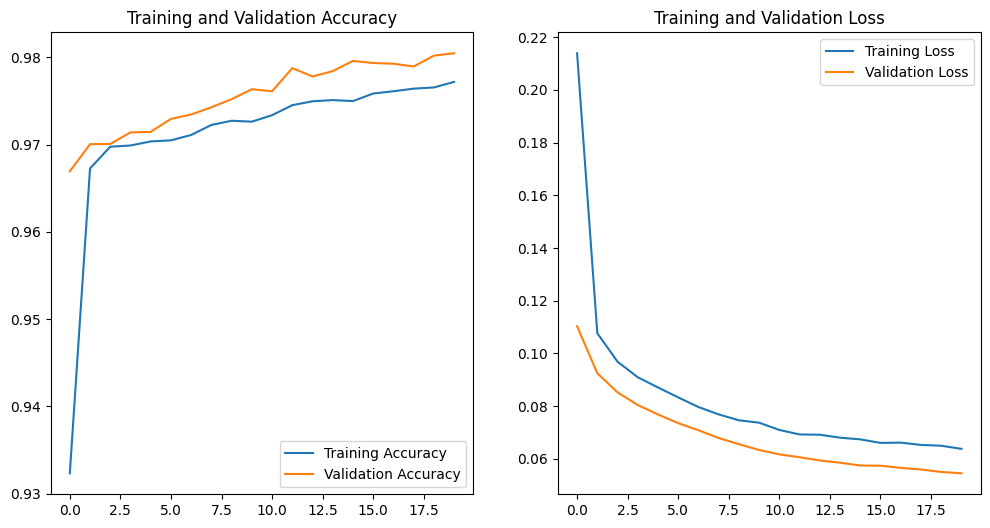

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('test.png')
plt.show()

# Testing

In [13]:
test_file_path = 'KDDTest+.txt'

# Read the text file into a DataFrame without headers
test_df = pd.read_csv(file_path, header=None)
test_df.columns = columns

# Drop columns not in the keep_columns list as we use packet tracing software
test_df = test_df[keep_columns]

# Assuming 'normal' means no attack and any other value is an anomaly
test_df['attack'] = test_df['attack'].apply(lambda x: 'normal' if x == 'normal' else 'anomaly')    
test_df.drop_duplicates(inplace=True)
print(f"New shape: {test_df.shape}")
print(test_df.head())

New shape: (125419, 28)
   duration protocol_type   service flag  src_bytes  dst_bytes  land  \
0         0           tcp  ftp_data   SF        491          0     0   
1         0           udp     other   SF        146          0     0   
2         0           tcp   private   S0          0          0     0   
3         0           tcp      http   SF        232       8153     0   
4         0           tcp      http   SF        199        420     0   

   wrong_fragment  urgent  count  ...  dst_host_count  dst_host_srv_count  \
0               0       0      2  ...             150                  25   
1               0       0     13  ...             255                   1   
2               0       0    123  ...             255                  26   
3               0       0      5  ...              30                 255   
4               0       0     30  ...             255                 255   

   dst_host_same_srv_rate  dst_host_diff_srv_rate  \
0                    0.17  

In [14]:
test_df['protocol_type'] = encoder1.transform(test_df['protocol_type'])
test_df['service'] = encoder2.transform(test_df['service'])
test_df['flag'] = encoder3.transform(test_df['flag'])

X_test = test_df.drop(columns = ['attack'])
y_test = test_df['attack']

y_test = attack_encoder.transform(y_test)


X_test_scaled = scaler.transform(X_test)

# PCA 
X_test_pca = pca.transform(X_test_scaled)


In [21]:
X_test_reshaped = X_test_pca.reshape((X_test_pca.shape[0], 1, X_test_pca.shape[1]))

# Converting into tensors
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_reshaped, y_test))

# Using the batch size = 32 and batching
batch_size = 32
test_dataset = test_dataset.batch(batch_size)

# prefetching
test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [22]:
X_test_reshaped.shape,y_test.shape

((125419, 1, 15), (125419,))

In [23]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_dataset)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')




3920/3920 ━━━━━━━━━━━━━━━━━━━━ 3s 804us/step - accuracy: 0.9808 - loss: 0.0545
Test Loss: 0.053553707897663116
Test Accuracy: 0.9809438586235046


In [24]:
predictions = model.predict(test_dataset)

# If you want to see some predictions
for i, pred in enumerate(predictions[:5]):  # Displaying the first 5 predictions
    print(f'Prediction {i+1}: {pred}')

3920/3920 ━━━━━━━━━━━━━━━━━━━━ 2s 602us/step
Prediction 1: [0.8396178]
Prediction 2: [0.67469144]
Prediction 3: [5.0148733e-06]
Prediction 4: [0.99964774]
Prediction 5: [0.99730694]


In [25]:
y_test[:5]

array([1, 1, 0, 1, 1])

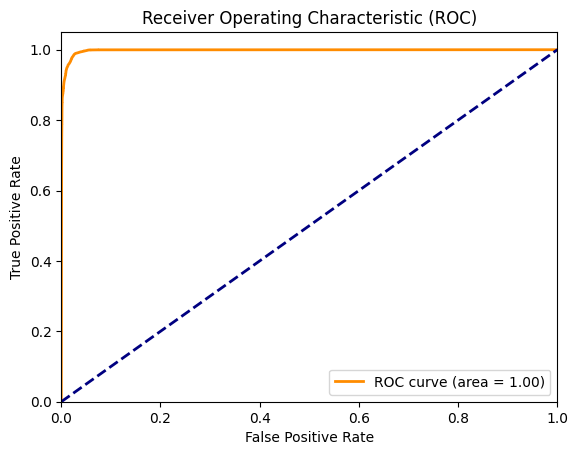

In [28]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, predictions)

# Step 4: Compute AUC (Area Under Curve) - Higher is better
roc_auc = auc(fpr, tpr)

# Step 5: Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [30]:
# Compute Youden's J statistic to find the optimal threshold
j_scores = tpr - fpr
best_threshold_index = np.argmax(j_scores)
best_threshold = thresholds[best_threshold_index]

print(f'Best Threshold (Maximizing TPR - FPR): {best_threshold:.2f}')

Best Threshold (Maximizing TPR - FPR): 0.54


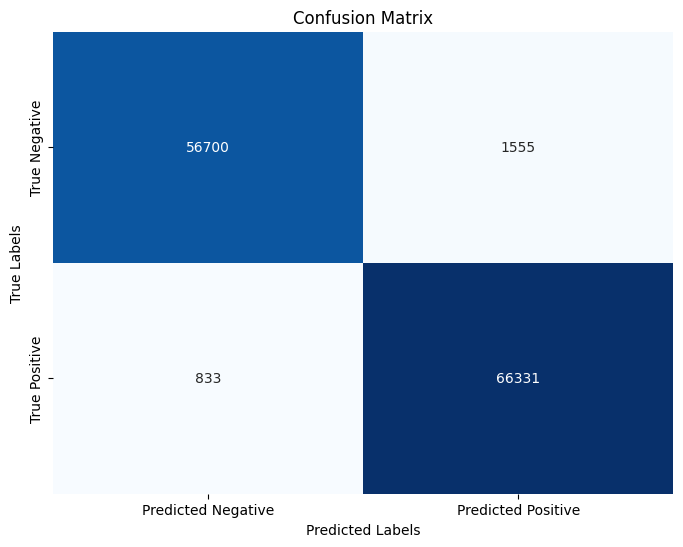

In [31]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
predicted_classes = np.where(predictions >= best_threshold, 1, 0)
cm = confusion_matrix(y_test, predicted_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['True Negative', 'True Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig('rnn_confusion_matrix')
plt.show()